In [47]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
import re

import math

from sklearn.preprocessing import StandardScaler

from sklearn.preprocessing import OneHotEncoder,StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from sklearn.linear_model import LinearRegression, Lasso
from sklearn.model_selection import cross_val_score


import scipy.stats as scs
import statsmodels.api as sm


%matplotlib inline

In [48]:
from fbprophet import Prophet

##### Read in the Data

In [2]:
raw_data = pd.read_csv('/Users/brandonmojica/Desktop/Galvanize/Capstones/Capstone_2/stockx_price_predict/data/StockX-Data-2019.csv')

##### Quick pass of the data to get an idea of what we are dealing with. 

In [3]:
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99956 entries, 0 to 99955
Data columns (total 8 columns):
Order Date      99956 non-null object
Brand           99956 non-null object
Sneaker Name    99956 non-null object
Sale Price      99956 non-null object
Retail Price    99956 non-null object
Release Date    99956 non-null object
Shoe Size       99956 non-null float64
Buyer Region    99956 non-null object
dtypes: float64(1), object(7)
memory usage: 6.1+ MB


In [4]:
raw_data.head()

,Order Date,Brand,Sneaker Name,Sale Price,Retail Price,Release Date,Shoe Size,Buyer Region
0,9/1/17,Yeezy,Adidas-Yeezy-Boost-350-Low-V2-Beluga,"$1,097",$220,9/24/16,11.0,California
1,9/1/17,Yeezy,Adidas-Yeezy-Boost-350-V2-Core-Black-Copper,$685,$220,11/23/16,11.0,California
2,9/1/17,Yeezy,Adidas-Yeezy-Boost-350-V2-Core-Black-Green,$690,$220,11/23/16,11.0,California
3,9/1/17,Yeezy,Adidas-Yeezy-Boost-350-V2-Core-Black-Red,"$1,075",$220,11/23/16,11.5,Kentucky
4,9/1/17,Yeezy,Adidas-Yeezy-Boost-350-V2-Core-Black-Red-2017,$828,$220,2/11/17,11.0,Rhode Island


#### Data Cleaning Pt 1: Remove the dollar signs for columns sale price and retial price

In [5]:
#Create a copy of the data just for backup
stockx_data = raw_data.copy()

In [6]:
def remove_unwanted_chars(string):
    
    """
    Inputs: string
    
    Description: A function that removes the "$" and "," and converts the string into an integer

    Returns: int
    
    """
    string = string.strip('$')
    string = string.replace(',','')
    string = int(string)
    
    return string

In [7]:
#Use the function remove_unwanted_chars to remove $ and ,
stockx_data['Retail Price'] = stockx_data['Retail Price'].apply(remove_unwanted_chars)

In [8]:
stockx_data['Sale Price'] = stockx_data['Sale Price'].apply(remove_unwanted_chars)

In [9]:
stockx_data.head()

,Order Date,Brand,Sneaker Name,Sale Price,Retail Price,Release Date,Shoe Size,Buyer Region
0,9/1/17,Yeezy,Adidas-Yeezy-Boost-350-Low-V2-Beluga,1097,220,9/24/16,11.0,California
1,9/1/17,Yeezy,Adidas-Yeezy-Boost-350-V2-Core-Black-Copper,685,220,11/23/16,11.0,California
2,9/1/17,Yeezy,Adidas-Yeezy-Boost-350-V2-Core-Black-Green,690,220,11/23/16,11.0,California
3,9/1/17,Yeezy,Adidas-Yeezy-Boost-350-V2-Core-Black-Red,1075,220,11/23/16,11.5,Kentucky
4,9/1/17,Yeezy,Adidas-Yeezy-Boost-350-V2-Core-Black-Red-2017,828,220,2/11/17,11.0,Rhode Island


In [10]:
#covert the order date to a datetime type. 
stockx_data['Order Date'] = stockx_data['Order Date'].astype('datetime64[ns]') 

In [11]:
stockx_data['Release Date'] = stockx_data['Release Date'].astype('datetime64[ns]') 

In [12]:
stockx_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99956 entries, 0 to 99955
Data columns (total 8 columns):
Order Date      99956 non-null datetime64[ns]
Brand           99956 non-null object
Sneaker Name    99956 non-null object
Sale Price      99956 non-null int64
Retail Price    99956 non-null int64
Release Date    99956 non-null datetime64[ns]
Shoe Size       99956 non-null float64
Buyer Region    99956 non-null object
dtypes: datetime64[ns](2), float64(1), int64(2), object(3)
memory usage: 6.1+ MB


In [13]:
stockx_data.head()

,Order Date,Brand,Sneaker Name,Sale Price,Retail Price,Release Date,Shoe Size,Buyer Region
0,2017-09-01,Yeezy,Adidas-Yeezy-Boost-350-Low-V2-Beluga,1097,220,2016-09-24,11.0,California
1,2017-09-01,Yeezy,Adidas-Yeezy-Boost-350-V2-Core-Black-Copper,685,220,2016-11-23,11.0,California
2,2017-09-01,Yeezy,Adidas-Yeezy-Boost-350-V2-Core-Black-Green,690,220,2016-11-23,11.0,California
3,2017-09-01,Yeezy,Adidas-Yeezy-Boost-350-V2-Core-Black-Red,1075,220,2016-11-23,11.5,Kentucky
4,2017-09-01,Yeezy,Adidas-Yeezy-Boost-350-V2-Core-Black-Red-2017,828,220,2017-02-11,11.0,Rhode Island


In [14]:
#convert the the order date into sperate cols 
stockx_data['Order year'] = stockx_data['Order Date'].dt.year 
stockx_data['Order month'] = stockx_data['Order Date'].dt.month 
stockx_data['Order day'] = stockx_data['Order Date'].dt.day

In [15]:
#convert the the release date into sperate cols 
stockx_data['Release year'] = stockx_data['Release Date'].dt.year 
stockx_data['Release month'] = stockx_data['Release Date'].dt.month 
stockx_data['Release day'] = stockx_data['Release Date'].dt.day

In [16]:
stockx_data.rename(columns={'Sneaker Name':'shoe'},inplace=True)

In [17]:
stockx_data.tail()

,Order Date,Brand,shoe,Sale Price,Retail Price,Release Date,Shoe Size,Buyer Region,Order year,Order month,Order day,Release year,Release month,Release day
99951,2019-02-13,Yeezy,adidas-Yeezy-Boost-350-V2-Static-Reflective,565,220,2018-12-26,8.0,Oregon,2019,2,13,2018,12,26
99952,2019-02-13,Yeezy,adidas-Yeezy-Boost-350-V2-Static-Reflective,598,220,2018-12-26,8.5,California,2019,2,13,2018,12,26
99953,2019-02-13,Yeezy,adidas-Yeezy-Boost-350-V2-Static-Reflective,605,220,2018-12-26,5.5,New York,2019,2,13,2018,12,26
99954,2019-02-13,Yeezy,adidas-Yeezy-Boost-350-V2-Static-Reflective,650,220,2018-12-26,11.0,California,2019,2,13,2018,12,26
99955,2019-02-13,Yeezy,adidas-Yeezy-Boost-350-V2-Static-Reflective,640,220,2018-12-26,11.5,Texas,2019,2,13,2018,12,26


In [18]:
#How many unique types of shoes are there
len(stockx_data['shoe'].unique())

50

In [19]:
#How many unique types of shoes are there
stockx_data['Brand'].unique()

array([' Yeezy', 'Off-White'], dtype=object)

In [20]:
stockx_data['shoe'].unique()

array(['Adidas-Yeezy-Boost-350-Low-V2-Beluga',
       'Adidas-Yeezy-Boost-350-V2-Core-Black-Copper',
       'Adidas-Yeezy-Boost-350-V2-Core-Black-Green',
       'Adidas-Yeezy-Boost-350-V2-Core-Black-Red',
       'Adidas-Yeezy-Boost-350-V2-Core-Black-Red-2017',
       'Adidas-Yeezy-Boost-350-V2-Core-Black-White',
       'Adidas-Yeezy-Boost-350-V2-Cream-White',
       'Adidas-Yeezy-Boost-350-V2-Zebra',
       'Adidas-Yeezy-Boost-350-Low-Moonrock', 'Nike-Air-Max-90-Off-White',
       'Nike-Air-Presto-Off-White', 'Nike-Air-VaporMax-Off-White',
       'Air-Jordan-1-Retro-High-Off-White-Chicago',
       'Nike-Blazer-Mid-Off-White',
       'Adidas-Yeezy-Boost-350-Low-Pirate-Black-2016',
       'Adidas-Yeezy-Boost-350-Low-Oxford-Tan',
       'Adidas-Yeezy-Boost-350-Low-Turtledove',
       'Adidas-Yeezy-Boost-350-Low-Pirate-Black-2015',
       'Adidas-Yeezy-Boost-350-V2-Semi-Frozen-Yellow',
       'Nike-Air-Force-1-Low-Off-White', 'Nike-Air-Max-97-Off-White',
       'Nike-Air-Force-1-Low-Virgil

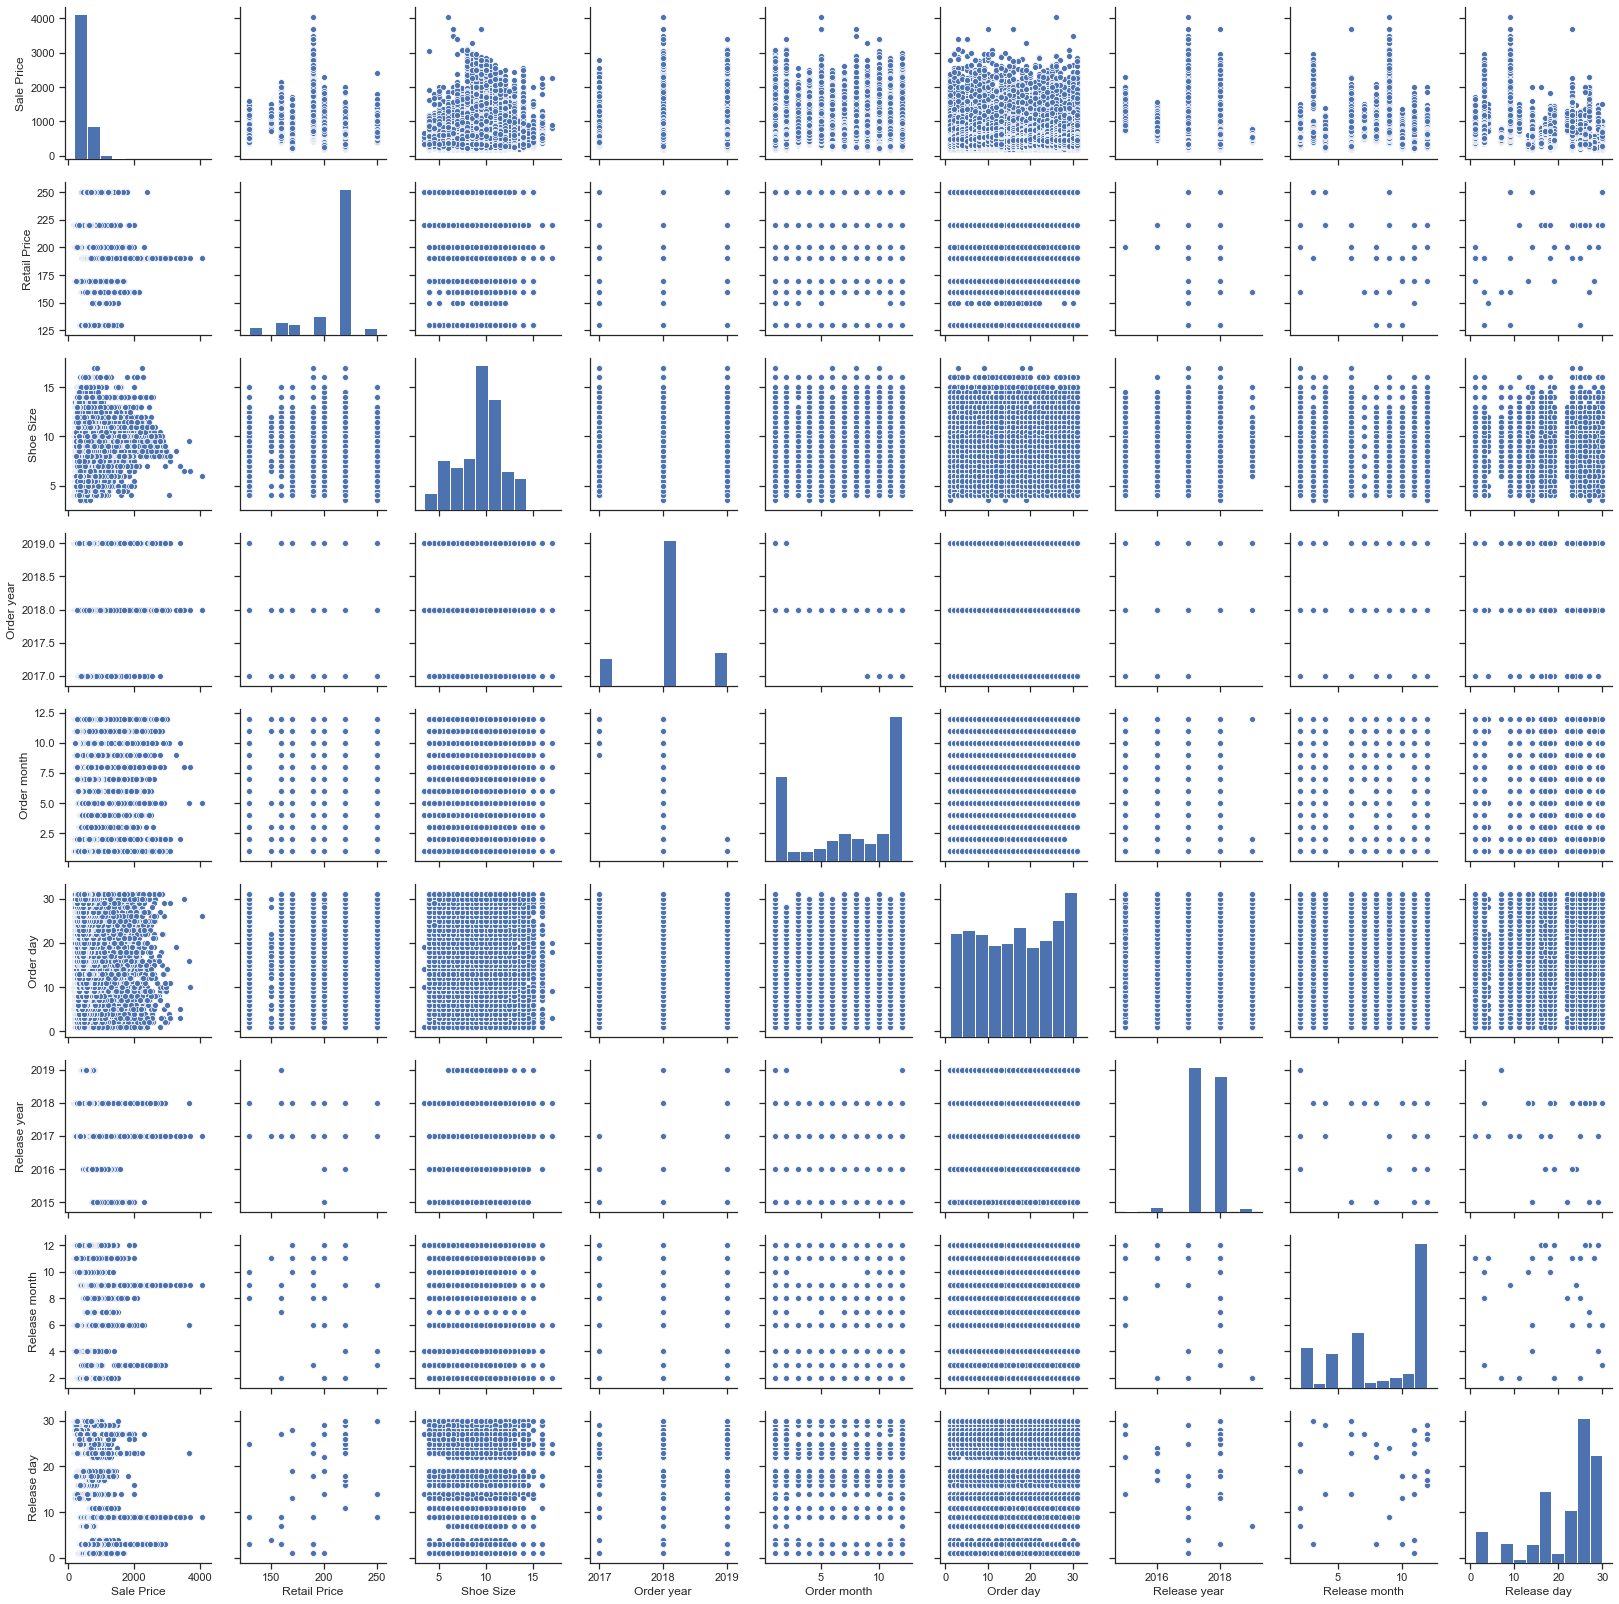

In [21]:
sns.set(style="ticks")
sns.pairplot(stockx_data)

In [22]:
stockx_data.groupby('Shoe Size')['Order Date'].count()

Shoe Size
3.5         4
4.0      2241
4.5      1304
5.0      3577
5.5      2621
6.0      4013
6.5      2219
7.0      3867
7.5      2664
8.0      5363
8.5      5300
9.0      9706
9.5      8685
10.0    11093
10.5     8784
11.0     9251
11.5     4502
12.0     7297
12.5      628
13.0     4602
13.5      147
14.0     1791
14.5       84
15.0      130
16.0       79
17.0        4
Name: Order Date, dtype: int64

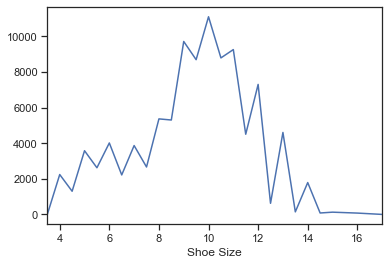

In [50]:
stockx_data.groupby('Shoe Size')['Order Date'].count().plot()

In [24]:
states = stockx_data.groupby('Buyer Region')['Order Date'].count().sort_values(ascending=False)

In [25]:
states_counts_df = states.to_frame()

In [26]:
states_counts_df.reset_index(inplace=True)

In [27]:
states_counts_df.rename(columns={'Order Date':'counts','Buyer Region':'states'},inplace=True)

In [28]:
states_counts_df

,states,counts
0,California,19349
1,New York,16525
2,Oregon,7681
3,Florida,6376
4,Texas,5876
5,New Jersey,4720
6,Illinois,3782
7,Pennsylvania,3109
8,Massachusetts,2903
9,Michigan,2762


In [29]:
top_20_states = states_counts_df[0:21]

In [30]:
top_20_states

,states,counts
0,California,19349
1,New York,16525
2,Oregon,7681
3,Florida,6376
4,Texas,5876
5,New Jersey,4720
6,Illinois,3782
7,Pennsylvania,3109
8,Massachusetts,2903
9,Michigan,2762


[Text(0, 0, 'California'),
 Text(0, 0, 'New York'),
 Text(0, 0, 'Oregon'),
 Text(0, 0, 'Florida'),
 Text(0, 0, 'Texas'),
 Text(0, 0, 'New Jersey'),
 Text(0, 0, 'Illinois'),
 Text(0, 0, 'Pennsylvania'),
 Text(0, 0, 'Massachusetts'),
 Text(0, 0, 'Michigan'),
 Text(0, 0, 'Virginia'),
 Text(0, 0, 'Ohio'),
 Text(0, 0, 'Maryland'),
 Text(0, 0, 'Washington'),
 Text(0, 0, 'Georgia'),
 Text(0, 0, 'Arizona'),
 Text(0, 0, 'North Carolina'),
 Text(0, 0, 'Delaware'),
 Text(0, 0, 'Connecticut'),
 Text(0, 0, 'Indiana'),
 Text(0, 0, 'Colorado')]

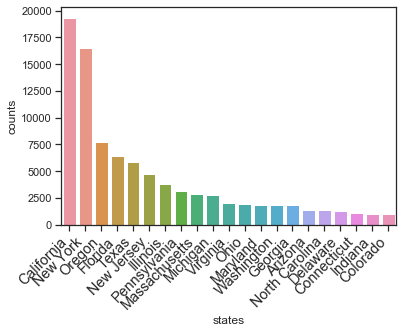

In [31]:
chart = sns.barplot(x='states', y= 'counts', data = top_20_states)
chart.set_xticklabels(
    chart.get_xticklabels(), 
    rotation=45, 
    horizontalalignment='right',
    fontweight='light',
    fontsize='large')

In [32]:
top_10_states = states_counts_df[0:11]

[Text(0, 0, 'California'),
 Text(0, 0, 'New York'),
 Text(0, 0, 'Oregon'),
 Text(0, 0, 'Florida'),
 Text(0, 0, 'Texas'),
 Text(0, 0, 'New Jersey'),
 Text(0, 0, 'Illinois'),
 Text(0, 0, 'Pennsylvania'),
 Text(0, 0, 'Massachusetts'),
 Text(0, 0, 'Michigan'),
 Text(0, 0, 'Virginia')]

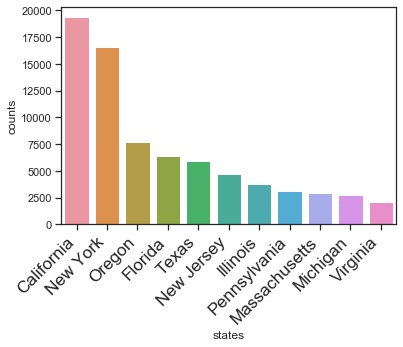

In [33]:
chart = sns.barplot(x='states', y= 'counts', data = top_10_states)
chart.set_xticklabels(
    chart.get_xticklabels(), 
    rotation=45, 
    horizontalalignment='right',
    fontweight='light',
    fontsize='x-large')

In [34]:
sneakers = stockx_data.groupby('shoe')['Order Date'].count().sort_values(ascending=False)

In [35]:
sneakers.to_frame()

,Order Date
shoe,
adidas-Yeezy-Boost-350-V2-Butter,11423
Adidas-Yeezy-Boost-350-V2-Beluga-2pt0,10395
Adidas-Yeezy-Boost-350-V2-Zebra,10110
Adidas-Yeezy-Boost-350-V2-Blue-Tint,9297
Adidas-Yeezy-Boost-350-V2-Cream-White,9097
Adidas-Yeezy-Boost-350-V2-Sesame,5553
adidas-Yeezy-Boost-350-V2-Static,4983
Adidas-Yeezy-Boost-350-V2-Semi-Frozen-Yellow,4854
Air-Jordan-1-Retro-High-Off-White-University-Blue,4635


In [36]:
top_10_sneakers = sneakers[0:11]

In [37]:
top_10_df = top_10_sneakers.to_frame()

In [38]:
top_10_df.rename(columns={'Order Date':'counts'},inplace=True)

In [39]:
top_10_df

,counts
shoe,
adidas-Yeezy-Boost-350-V2-Butter,11423
Adidas-Yeezy-Boost-350-V2-Beluga-2pt0,10395
Adidas-Yeezy-Boost-350-V2-Zebra,10110
Adidas-Yeezy-Boost-350-V2-Blue-Tint,9297
Adidas-Yeezy-Boost-350-V2-Cream-White,9097
Adidas-Yeezy-Boost-350-V2-Sesame,5553
adidas-Yeezy-Boost-350-V2-Static,4983
Adidas-Yeezy-Boost-350-V2-Semi-Frozen-Yellow,4854
Air-Jordan-1-Retro-High-Off-White-University-Blue,4635


In [40]:
top_10_df.reset_index(inplace=True)

[Text(0, 0, 'adidas-Yeezy-Boost-350-V2-Butter'),
 Text(0, 0, 'Adidas-Yeezy-Boost-350-V2-Beluga-2pt0'),
 Text(0, 0, 'Adidas-Yeezy-Boost-350-V2-Zebra'),
 Text(0, 0, 'Adidas-Yeezy-Boost-350-V2-Blue-Tint'),
 Text(0, 0, 'Adidas-Yeezy-Boost-350-V2-Cream-White'),
 Text(0, 0, 'Adidas-Yeezy-Boost-350-V2-Sesame'),
 Text(0, 0, 'adidas-Yeezy-Boost-350-V2-Static'),
 Text(0, 0, 'Adidas-Yeezy-Boost-350-V2-Semi-Frozen-Yellow'),
 Text(0, 0, 'Air-Jordan-1-Retro-High-Off-White-University-Blue'),
 Text(0, 0, 'adidas-Yeezy-Boost-350-V2-Static-Reflective'),
 Text(0, 0, 'Nike-Air-Presto-Off-White-Black-2018')]

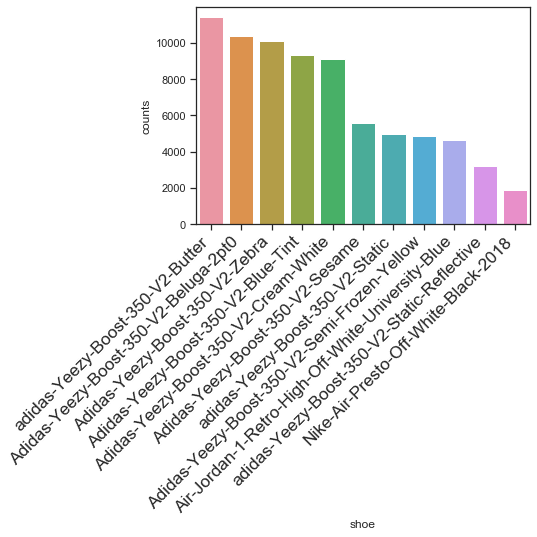

In [41]:
chart = sns.barplot(x='shoe', y= 'counts', data = top_10_df)

chart.set_xticklabels(
    chart.get_xticklabels(), 
    rotation=45, 
    horizontalalignment='right',
    fontweight='light',
    fontsize='x-large')

In [42]:
avg_sale_price = stockx_data.groupby('shoe').mean()

In [43]:
# Compute the avergae of the types of shoes and add it to the df
stockx_data['average_sale_price'] = stockx_data['Sale Price'].groupby(stockx_data['shoe']).transform('mean')

In [44]:
#compute the price premium for the shoe
stockx_data['shoe_premium'] = (stockx_data['average_sale_price'] - stockx_data['Retail Price'])/stockx_data['Retail Price']

In [45]:
#compute the price premium for the shoe
stockx_data['2017_annual_high'] = stockx_data['Sale Price'].groupby(stockx_data['']).transform('mean')

KeyError: ''

In [ ]:
stockx_data['annual_high'] = stockx_data[stockx_data['Order year']==2017 ].groupby('shoe')['Sale Price'].transform('max')

In [ ]:
stockx_data['annual_high'].where(stockx_data['Order year']==2018)

#stockx_data[stockx_data['Order year']==2018 ].groupby('shoe')['Sale Price'].transform('max')





In [ ]:
stockx_data['Sale Price'].groupby(stockx_data['shoe']).max()

#stockx_data['average_sale_price'] = stockx_data['Sale Price'].groupby(stockx_data['shoe']).transform('mean')

In [ ]:
(788.704819 - 220)/220

In [ ]:
2.585022 * 220

In [51]:
stockx_data.head()

,Order Date,Brand,shoe,Sale Price,Retail Price,Release Date,Shoe Size,Buyer Region,Order year,Order month,Order day,Release year,Release month,Release day,average_sale_price,shoe_premium
0,2017-09-01,Yeezy,Adidas-Yeezy-Boost-350-Low-V2-Beluga,1097,220,2016-09-24,11.0,California,2017,9,1,2016,9,24,788.704819,2.585022
1,2017-09-01,Yeezy,Adidas-Yeezy-Boost-350-V2-Core-Black-Copper,685,220,2016-11-23,11.0,California,2017,9,1,2016,11,23,656.631111,1.984687
2,2017-09-01,Yeezy,Adidas-Yeezy-Boost-350-V2-Core-Black-Green,690,220,2016-11-23,11.0,California,2017,9,1,2016,11,23,622.801020,1.830914
3,2017-09-01,Yeezy,Adidas-Yeezy-Boost-350-V2-Core-Black-Red,1075,220,2016-11-23,11.5,Kentucky,2017,9,1,2016,11,23,937.754967,3.262523
4,2017-09-01,Yeezy,Adidas-Yeezy-Boost-350-V2-Core-Black-Red-2017,828,220,2017-02-11,11.0,Rhode Island,2017,9,1,2017,2,11,804.304438,2.655929


In [ ]:
stockx_data['log_shoe_premium'] = np.log(stockx_data['shoe_premium'])

In [ ]:
scaler = StandardScaler()

In [ ]:
scaler.fit(stockx_data['shoe_premium'].reshape(-1, 1))
scaler.transform(stockx_data['shoe_premium'].reshape(-1, 1))

In [ ]:

fig = plt.figure(figsize=(10,4))
sns.distplot(stockx_data['log_shoe_premium'] , bins = 10)
plt.ylabel('Count')

In [ ]:
sns.distplot(stockx_data['shoe_premium'] , bins = 30)

In [ ]:
sns.distplot(stockx_data['log_2_shoe_premium'] , bins = 10)

In [ ]:
stockx_data['shoe_premium'].hist(bins=25)



In [ ]:
stockx_data['log_shoe_premium'].hist(bins=15)

In [ ]:
stockx_data.describe()

In [ ]:
stockx_data.tail()

In [ ]:
avg_sale_price['Sale Price']

In [ ]:
test_txt = 'Adidas-Yeezy-Boost-350-Low-V2-Beluga'
test_txt.split('-')

In [ ]:
stockx_data.head()

In [ ]:
stockx_data['Order year'].unique()

In [ ]:
stockx_data['Release year'].unique()

In [ ]:
sneakers = stockx_data.groupby('shoe')['Order Date'].count().sort_values(ascending=False)

In [ ]:
order_dates = stockx_data.groupby(['Order Date','shoe'])['Sale Price'].sum(ascending=True)

In [ ]:
order_dates

In [ ]:
resell_price_df = stockx_data.groupby('Brand')['Sale Price'].sum().to_frame()

In [ ]:
retail_price_df = stockx_data.groupby('Brand')['Retail Price'].sum().to_frame()

In [ ]:
resell_price_df.reset_index(inplace=True)

In [ ]:
retail_price_df.reset_index(inplace=True)

In [ ]:
resell_price_df

In [ ]:
retail_price_df

## Create the Yeezy Data Frame

In [ ]:
yeezy_df = stockx_data[stockx_data['Brand']==' Yeezy']

In [ ]:
def strip_brand_yeezy(string):
    """
    Input: shoe string 
    Output: shoe string
    """
    
    string = re.sub('-Yeezy', '',string)
    return string

In [ ]:
yeezy_df['shoe'] = yeezy_df['shoe'].apply(strip_brand_yeezy)

In [ ]:
yeezy_df.head(5)

In [ ]:
yeezy_df.describe()

In [ ]:
off_white_df = stockx_data[stockx_data['Brand']=='Off-White']

In [ ]:
off_white_df.head()

In [ ]:
off_white_df['shoe'] = off_white_df['shoe'].apply(strip_brand_off)

In [ ]:
def strip_brand_off(string):
    """
    Input: shoe string 
    Output: shoe string
    """
    
    string = re.sub('-Off-White', '',string)
    return string

In [ ]:
strip_brand(test)

In [ ]:
test = 'Nike-Air-Masdfsdfadx-90-Off-White'

In [ ]:
off_white_df['shoe'].unique()

## Computed the mark up of a shoe and placed into it's own column

In [ ]:
stockx_data['mark_up'] = stockx_data['Sale Price'] - stockx_data['Retail Price']

In [ ]:
stockx_data.describe()

In [ ]:
stockx_data.info()

## Create the dummies for the categorical columns

In [ ]:
shoe_dummy = pd.get_dummies(stockx_data['Shoe Size'])

In [ ]:
shoe_dummy

In [ ]:
release_year_data_dummy = pd.get_dummies(stockx_data['Release year'])

In [ ]:
release_year_data_dummy.head()

In [ ]:
brand_dummy = pd.get_dummies(stockx_data['Brand'])

In [ ]:
brand_dummy

In [ ]:
state_dummy = pd.get_dummies(stockx_data['Buyer Region'])

In [ ]:
state_dummy

In [ ]:
order_month_dummy = pd.get_dummies(stockx_data['Order month'])

In [ ]:
order_day_dummy = pd.get_dummies(stockx_data['Order day'])

In [ ]:
order_year_dummy = pd.get_dummies(stockx_data['Order year'])

In [ ]:
release_month_dummy = pd.get_dummies(stockx_data['Release month'])

In [ ]:
release_day_dummy = pd.get_dummies(stockx_data['Release day'])

In [ ]:
shoe_type_dummy = pd.get_dummies(stockx_data['shoe'])

In [ ]:
dummy_df_2 = pd.concat([stockx_data,shoe_dummy,shoe_type_dummy,brand_dummy], axis=1)



In [ ]:
X = dummy_df_2.drop(columns=['shoe_premium','avg_sale_price'])

y = dummy_df_2['shoe_premium']           

In [ ]:
import statsmodels.api as sm # import statsmodels 

X = dummy_df_2.drop(columns=['shoe_premium'])
## X usually means our input variables (or independent variables)
y = dummy_df_2["shoe_premium"] ##Y usually means our output/dependent variable
X = sm.add_constant(X) ## let's add an intercept (beta_0) to our model

# Note the difference in argument order
model = sm.OLS(y, X).fit() ## sm.OLS(output, input)
predictions = model.predict(X)

# Print out the statistics
model.summary()

In [ ]:
dummy_df_2.drop(columns=['Brand','Shoe Size','Buyer Region','Release Date','shoe','Release year','Release month','Release day','Order year','Order month','Order day'],inplace=True)

In [ ]:
dummy_df_2.drop(columns=['Order Date','annual_high','log_shoe_premium'],inplace=True)



In [ ]:
dummy_df_2.info()

In [ ]:
stockx_data.head()

In [ ]:
dummy_df.drop(columns=['Brand','Shoe Size','Buyer Region','Release Date','shoe','Release year','Release month','Release day','Order year','Order month','Order day'],inplace=True)





In [ ]:
dummy_df.drop(columns=['Order Date'],inplace=True)

In [ ]:
target = dummy_df['Sale Price'] 

In [ ]:
# X = sm.add_constant(X)
# model = sm.OLS(y, X).fit()
# summary = model.summary()


X = dummy_df.copy()
y = X.pop('Sale Price')

X = sm.add_constant(X)
model = sm.OLS(y, X).fit()
summary = model.summary()

    
# summary_model(X, y)

In [ ]:
summary

In [ ]:
dummy_df

In [ ]:
yeezy_shoe_size = pd.get_dummies(yeezy_df['Shoe Size'])
yeezy_dummy_df = pd.concat([yeezy_df['Sale Price'],yeezy_shoe_size], axis=1)



In [ ]:
yeezy_dummy_df

In [ ]:
yeezy_dummy_df.columns

In [ ]:
yeezy_dummy_df[3.5]

In [ ]:
import statsmodels.api as sm # import statsmodels 

X = stock[[' Yeezy','Off-White','']]
## X usually means our input variables (or independent variables)
y = dummy_df["Sale Price"] ##Y usually means our output/dependent variable
X = sm.add_constant(X) ## let's add an intercept (beta_0) to our model

# Note the difference in argument order
model = sm.OLS(y, X).fit() ## sm.OLS(output, input)
predictions = model.predict(X)

# Print out the statistics
model.summary()

In [ ]:
yeezy_df

In [ ]:
yeezy_df.head()

In [ ]:
x = stockx_data['']

In [ ]:
stockx_2017 = stockx_data[stockx_data['Order year'] == 2017]
stockx_2018 = stockx_data[stockx_data['Order year'] == 2018]
stockx_2019 = stockx_data[stockx_data['Order year'] == 2019]

In [ ]:
stockx_2017.describe()

In [ ]:
stockx_2018.describe()

In [ ]:
stockx_2019.describe()

In [ ]:
stockx_2017['Order month'].unique()

In [ ]:
stockx_2017

In [ ]:
stockx_2017.head()

In [ ]:
stockx_2017.groupby(['Order Date']).mean()

In [ ]:
top_shoes_sold_average_2017 = stockx_2017.groupby('shoe')['Sale Price'].mean().sort_values(ascending=False)

In [ ]:
top_shoes_sold_average_2017_df = top_shoes_sold_average_2017.to_frame().reset_index()

In [ ]:
top_shoes_sold_average_2017_df.iloc[0:5]

In [ ]:
top_2017_arr = []

for i in top_shoes_sold_average_2017_df.iloc[0:5]['shoe']:
    top_2017_arr.append(i)

In [ ]:
top_2017_arr

In [ ]:
top_shoes_sold_average_2017

In [ ]:
stockx_2017 = stockx_2017.set_index('Order Date')

In [ ]:
shoes_arr = stockx_2017['shoe'].unique()

In [ ]:
x = stockx_2017[stockx_2017['shoe'] == 'Adidas-Yeezy-Boost-350-Low-V2-Beluga']

In [ ]:
shoe_2017_1 = stockx_2017[stockx_2017['shoe'] == top_2017_arr[0]]
shoe_2017_2 = stockx_2017[stockx_2017['shoe'] == top_2017_arr[1]]
shoe_2017_3 = stockx_2017[stockx_2017['shoe'] == top_2017_arr[2]]
shoe_2017_4 = stockx_2017[stockx_2017['shoe'] == top_2017_arr[3]]
shoe_2017_5 = stockx_2017[stockx_2017['shoe'] == top_2017_arr[4]]

In [ ]:
x = shoe_2017_1[['shoe','Sale Price']]

In [ ]:
stockx_2017['shoe'].max()

In [ ]:
fig, ax = plt.subplots(figsize=(40,20))

a = shoe_2017_1['Sale Price']
b = shoe_2017_2['Sale Price']
c = shoe_2017_3['Sale Price']
d = shoe_2017_4['Sale Price']
e = shoe_2017_5['Sale Price']

plt.plot(a,'r',label=top_2017_arr[0])
plt.plot(b,'b', label=top_2017_arr[1])
plt.plot(c,'g',label=top_2017_arr[2])
plt.plot(d,'y',label=top_2017_arr[3])
plt.plot(e,'c',label=top_2017_arr[4])

plt.title('2017 Top 5 Shoes by Price',fontsize=40)
plt.xlabel('Date',fontsize=40)
plt.ylabel('Price',fontsize=40)

plt.legend(prop={'size': 30})

plt.show()

In [ ]:
top_shoes_sold_average_2018 = stockx_2018.groupby('shoe')['Sale Price'].mean().sort_values(ascending=False)

In [ ]:
test = stockx_2018.groupby('shoe')['Sale Price'].mean().sort_values(ascending=False)

In [ ]:
top_shoes_sold_average_2018_df = top_shoes_sold_average_2018.to_frame().reset_index()
top_shoes_sold_average_2018_df.iloc[0:5]

In [ ]:
top_2018_arr = []

for i in top_shoes_sold_average_2018_df.iloc[0:5]['shoe']:
    top_2018_arr.append(i)

In [ ]:
top_2018_arr

In [ ]:
stockx_2018 = stockx_2018.set_index('Order Date')

In [ ]:
shoe_2018_1 = stockx_2018[stockx_2018['shoe'] == top_2018_arr[0]]
shoe_2018_2 = stockx_2018[stockx_2018['shoe'] == top_2018_arr[1]]
shoe_2018_3 = stockx_2018[stockx_2018['shoe'] == top_2018_arr[2]]
shoe_2018_4 = stockx_2018[stockx_2018['shoe'] == top_2018_arr[3]]
shoe_2018_5 = stockx_2018[stockx_2018['shoe'] == top_2018_arr[4]]

In [ ]:
fig, ax = plt.subplots(figsize=(40,20))

a = shoe_2018_1['Sale Price']
b = shoe_2018_2['Sale Price']
c = shoe_2018_3['Sale Price']
d = shoe_2018_4['Sale Price']
e = shoe_2018_5['Sale Price']

plt.plot(a,'r',label=top_2018_arr[0])
plt.plot(b,'b', label=top_2018_arr[1])
plt.plot(c,'g',label=top_2018_arr[2])
plt.plot(d,'y',label=top_2018_arr[3])
plt.plot(e,'c',label=top_2018_arr[4])

plt.title('2018 Top 5 Shoes by Price',fontsize=40)
plt.xlabel('Date',fontsize=40)
plt.ylabel('Price',fontsize=40)

plt.legend(prop={'size': 30})

plt.show()

In [ ]:
top_shoes_sold_average_2019 = stockx_2019.groupby('shoe')['Sale Price'].mean().sort_values(ascending=False)

In [ ]:
top_shoes_sold_average_2019_df = top_shoes_sold_average_2019.to_frame().reset_index()
top_shoes_sold_average_2019_df.iloc[0:5]

In [ ]:
top_2019_arr = []

for i in top_shoes_sold_average_2019_df.iloc[0:5]['shoe']:
    top_2019_arr.append(i)

In [ ]:
stockx_2019 = stockx_2019.set_index('Order Date')

In [ ]:
top_2018_arr

In [ ]:
shoe_2019_1 = stockx_2019[stockx_2019['shoe'] == top_2019_arr[0]]
shoe_2019_2 = stockx_2019[stockx_2019['shoe'] == top_2019_arr[1]]
shoe_2019_3 = stockx_2019[stockx_2019['shoe'] == top_2019_arr[2]]
shoe_2019_4 = stockx_2019[stockx_2019['shoe'] == top_2019_arr[3]]
shoe_2019_5 = stockx_2019[stockx_2019['shoe'] == top_2019_arr[4]]

In [ ]:
fig, ax = plt.subplots(figsize=(40,20))

a = shoe_2019_1['Sale Price']
b = shoe_2019_2['Sale Price']
c = shoe_2019_3['Sale Price']
d = shoe_2019_4['Sale Price']
e = shoe_2019_5['Sale Price']

plt.plot(a,'r',label=top_2019_arr[0])
plt.plot(b,'b', label=top_2019_arr[1])
plt.plot(c,'g',label=top_2019_arr[2])
plt.plot(d,'y',label=top_2019_arr[3])
plt.plot(e,'c',label=top_2019_arr[4])

plt.title('2019 Top 5 Shoes by Avg Price',fontsize=40)
plt.xlabel('Date',fontsize=40)
plt.ylabel('Price',fontsize=40)

plt.legend(prop={'size': 30})

plt.show()

In [ ]:
stockx_data.head()

In [ ]:
y = stockx_data['pre']